# Colab
Tijdens de lessen van Raoul bleek dat bij veel studenten (ook bij mij) het niet lukte om een neuraal netwerk te trainen met behulp van een GPU. Als oplossing heeft Raoul toen aanbevolen om Google Colab te gebruiken. <br>
Hiervoor moet soms wel de code worden aangepast. Ik heb geprobeerd dit notebook zo te maken dat het zowel in Colab als op een laptop/PC kan draaien, maar alleen in Colab wordt dus gebruik gemaakt van een GPU.

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
    datadir_processed = Path("../data/processed")
    datadir_model = Path("../models")
    
if IS_COLAB:
    !git clone https://github.com/Lenkus1/HuubS_ML_Opdracht.git
    %cd HuubS_ML_Opdracht/template
    %pip install loguru
    %pip install -q -U keras-tuner
    datadir_processed = "/content/HuubS_ML_Opdracht/template/data/processed"
    datadir_model = "/content/HuubS_ML_Opdracht/template/models"

Cloning into 'HuubS_ML_Opdracht'...
remote: Enumerating objects: 35603, done.
remote: Counting objects: 100% (35603/35603), done.
remote: Compressing objects: 100% (35530/35530), done.
remote: Total 35603 (delta 99), reused 35544 (delta 63), pack-reused 0
Receiving objects: 100% (35603/35603), 159.56 MiB | 36.87 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (17793/17793), done.
/content/HuubS_ML_Opdracht/template
     |████████████████████████████████| 58 kB 2.4 MB/s 
     |████████████████████████████████| 98 kB 4.1 MB/s 


# Convolutional Neural Network (CNN)

Een CNN is op dit moment het beste algoritme voor het verwerken van afbeeldingen. Een CNN reduceert de complexiteit en maakt het netwerk geschikter voor zijn taak. <br> 
Over het algemeen heeft een pixel linksboven in een foto immers weinig te maken met een pixel rechtsonder. Bij CNN's worden afbeeldingen opgedeeld in kleine rasters van goed behapbare stukjes. <br>
Ik verwacht dat deze techniek het beste presteert op mijn dataset. Maar HOE goed is de vraag. Ik verwacht in ieder geval voor de klasses 2 en 3 (De 'Disturbed' en de cigar) nog steeds geen hele goede resultaten. <br>
Hoe goed het algoritme ook is, als de input data niet goed is zal het resultaat nog steeds mager zijn.


In [5]:
# laden van libraries

%load_ext autoreload
%autoreload 2

%pip install keras-tuner

from pathlib import Path
import os
import sys
sys.path.insert(0, "..")
sys.path

# loading libraries, some settings for plots

import numpy as np
import seaborn as sns
sns.set_theme()

import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt
from keras_tuner import HyperModel

import random as python_random
from collections import Counter

from typing import Dict, List, Tuple

# voor reproduceerbaarheid resulaten (tips gevonden via Google)
os.environ['PYTHONHASHSEED']=str(42)
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   python_random.seed(42)
  

reset_random_seeds()


In [6]:
def cfm_heatmap(
    cfm: np.ndarray,
    figsize: tuple = (8, 8),
    scale: float = None,
    labels: List[str] = None,
    vmin: float = None,
    vmax: float = None,
) -> None:
    """
    figsize: tuple, default (8,8)
    scale: string. The direction over which the numbers are scaled.
        Either None, 'total', 'rowwise' or 'colwise'
    """

    if scale == "total":
        cfm_norm = cfm / np.sum(cfm)
    elif scale == "rowwise":
        cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
    elif scale == "colwise":
        cfm_norm = cfm / np.sum(cfm, axis=0, keepdims=True)
    else:
        cfm_norm = cfm
    plt.figure(figsize=figsize)
    if labels is not None:
        plot = sns.heatmap(
            cfm_norm,
            annot=cfm_norm,
            vmin=vmin,
            vmax=vmax,
            xticklabels=labels,
            yticklabels=labels,
        )
    else:
        plot = sns.heatmap(cfm_norm, annot=cfm_norm, vmin=vmin, vmax=vmax)
    plot.set(xlabel="Predicted", ylabel="Target")


We bepalen weer de datasets. We maken nu naast een train- en testset ook een validatieset, zodat we een unbiased set hebben om het uiteindelijke model op te toetsen.

In [7]:
data = []
labels = []

for f in sorted(os.listdir(datadir_processed)):
    folder = os.path.join(datadir_processed, f)
    if os.path.isdir(folder):
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(folder)):
            image=tf.keras.preprocessing.image.load_img(folder+'/'+i, 
            target_size= (64,64))
            image=np.array(image)
            data.append(image)
            labels.append(f)

data = np.array(data)
labels = list(labels)

encoder = LabelEncoder() # het CNN wil numerieke waardes ipv tekstklasses
labels = encoder.fit_transform(labels)


X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,
                                                shuffle=True,
                                                random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25,
                                                random_state=42)


# Pre-processing
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255
X_valid = X_valid.astype('float32') / 255

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)


(10641, 64, 64, 3)
(3548, 64, 64, 3)
(3547, 64, 64, 3)


# Het CNN model bouwen

Ik ben wel een week bezig geweest om allerlei modellen te bouwen en te testen. Het model hieronder is waar ik uiteindelijk op uitgekomen ben.

Het bestaat uit de volgende onderdelen:

## Data augmentation
Dit is een techniek die zorgt voor meer trainingsvoorbeelden. Dit kan er voor zorgen dat het model robuuster wordt en beter kan generaliseren.<br> 
Ik heb hier ook voor gekozen omdat de 'cigar shape smooth' klasse relatief weinig beelden heeft.
Ik gebruik flip, rotation, translation en zoom. Dit lijkt goed te passen bij het soort beelden.

## Convolutional layers
Ik ben uitgekomen op 3 convolutional layers. Ik heb ook modellen geprobered met meer layers maar de performance werd niet beter, maar de doorlooptijd nam wel toe. <br>
3 layers geeft de hypertuning wat mogelijkheden om te variëren met de verschillende parameters.

### Aantal filters
Het aantal filters wordt door hypertuning bepaald, maar een range tussen 32 en 128 lijkt goed als ik kijk naar voorbeelden van allerlei architecturen.

### Kernel size
De kernel size wordt door hypertuning bepaald, maar een range tussen 3 en 7 lijkt goed als ik kijk naar voorbeelden van allerlei architecturen. <br>
De plaatjes zijn ook maar 64x64 pixels groot.

### Kernel Initializer
Om exploding/vanishing gradients tegen te gaan voeg ik een KI toe. 

### Kernel Regulizer
Het model gaat behoorlijk overfitten, om dat tegen te gaan voeg ik een regulizer toe die gewichten en penalties toekent.

## Activation
Ik gebruik LeakyRelu bij de Convolutional Layers omdat dat bij mijn experimenten iets betere scores opleverde. Bij de Dense layers laat ik de hypertuner kiezen.

## Max pooling
Verwijdert niet-relevante elementen en maakt het model robuuster voor wijzigingen in de invoer.

## Batch normalization
Dit versnelt het trainingsproces en normaliseert de data in het model.

## Dropout
Ook dit helpt tegen overfitten. Ik laat de hypertuning zoeken wat goed werkt tussen 0.05 en 0.25.

## Dense layers
3 Dense layers (de laatste voor de output) is vrij gebruikelijk. Ik laat hypertuning het aantal units bepalen, <br> 
maar geef een grotere range voor de eerste laag, zodat een soort 'trechter' ontstaat.



In [8]:
INPUT_SHAPE = (64, 64, 3)
NUM_CLASSES = 10

class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        
        KI='he_uniform'
        KR=regularizers.l2(hp.Float('l2', min_value=0.001, max_value=0.005, default=0.002, step=0.001))
      
        data_augmentation = tf.keras.Sequential([
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomTranslation(0.1, 0.1),
        keras.layers.RandomZoom(0.2),
        ])

        
        model = keras.Sequential()

        data_augmentation

        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_1', # laag 1
        values=[32, 64, 96, 128], default=32), kernel_size=
        hp.Choice('num_kernels1',values=[3, 5, 7], default=5),
        kernel_initializer=KI, kernel_regularizer=KR, 
        input_shape=self.input_shape))
        
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_2', # laag 2
        values=[32, 64, 96, 128], default=32), kernel_size=
        hp.Choice('num_kernels2',values=[3, 5, 7], default=5),
        kernel_regularizer=KR))
        
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.MaxPooling2D(pool_size=2))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_1', 
        min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
              
        model.add(keras.layers.Conv2D(filters=hp.Choice('num_filters_3', # laag 3
        values=[32, 64, 96, 128], default=64), kernel_size=
        hp.Choice('num_kernels3',values=[3, 5, 7], default=5),
        kernel_regularizer=KR))
        
        model.add(keras.layers.LeakyReLU(alpha=0.2))
        model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Flatten())
        
        model.add(keras.layers.Dense(units=hp.Int('units_1', min_value=32, # laag 1
        max_value=256, step=32, default=128), 
        activation=hp.Choice('dense_activation', 
        values=['relu', 'tanh', 'sigmoid'], default='relu'),
        kernel_regularizer=KR))
        
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_2', 
        min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        
        model.add(keras.layers.Dense(units=hp.Int('units_2', min_value=32, # laag 2
        max_value=128, step=16, default=64), 
        activation=hp.Choice('dense_activation', 
        values=['relu', 'tanh', 'sigmoid'], default='relu'),
        kernel_regularizer=KR))
        
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        
        model.add(keras.layers.Dense(self.num_classes, activation='softmax')) # laag 3

        
        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG',
                    default=1e-3
                )
            ),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

hypermodel = CNNHyperModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

Nu bouw ik de hypertuner. Ik tune op de val_accuracy want het model moet goed werken op andere data dan de trainingsset. Op de trainset gaat de accuracy al snel over de 90%. <br>
Ik tune maximaal 20 epochs omdat het anders veel te lang gaat duren, en uit mijn experimenten blijkt dat de beste scores al eerder worden bereikt.

In [9]:
from kerastuner.tuners import Hyperband

tuner = kt.Hyperband(
    hypermodel,
    overwrite=True,
    objective='val_accuracy',
    max_epochs=20,
    executions_per_trial=1,
    hyperband_iterations=1,
    directory=datadir_model,
    project_name='galaxies'
    )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """Entry point for launching an IPython kernel.


In [10]:
tuner.search_space_summary() # samenvatting van mogelijke parameters in het model

Search space summary
Default search space size: 14
l2 (Float)
{'default': 0.002, 'conditions': [], 'min_value': 0.001, 'max_value': 0.005, 'step': 0.001, 'sampling': None}
num_filters_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels1 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
num_filters_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels2 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
dropout_1 (Float)
{'default': 0.25, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.05, 'sampling': None}
num_filters_3 (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 96, 128], 'ordered': True}
num_kernels3 (Choice)
{'default': 5, 'conditions': [], 'values': [3, 5, 7], 'ordered': True}
units_1 (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
dens

# Hypertuning

### <font color='red'>Let op! Duurt 10 uur op CPU / 1 uur op Colab GPU</font>

Om overfitting te voorkomen gebruik ik EarlyStopping als de validation loss begint toe te nemen na een plateau, met een patience van 2 om een incidentele stijging te negeren.

In [11]:
tuner.search(X_train, y_train,
             validation_data=(X_valid, y_valid),
             callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=2)])

Trial 30 Complete [00h 01m 05s]
val_accuracy: 0.43811672925949097

Best val_accuracy So Far: 0.6566112041473389
Total elapsed time: 00h 31m 35s
INFO:tensorflow:Oracle triggered exit


Na 30 trials beslist de tuner dat er geen verbetering meer is en stopt het tunen. De beste uitslagen staan hieronder.

In [12]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in /content/HuubS_ML_Opdracht/template/models/galaxies
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
l2: 0.004
num_filters_1: 32
num_kernels1: 7
num_filters_2: 64
num_kernels2: 5
dropout_1: 0.05
num_filters_3: 128
num_kernels3: 5
units_1: 160
dense_activation: sigmoid
dropout_2: 0.0
units_2: 80
dropout_3: 0.2
learning_rate: 0.0002588664435216088
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6566112041473389
Trial summary
Hyperparameters:
l2: 0.002
num_filters_1: 64
num_kernels1: 5
num_filters_2: 32
num_kernels2: 7
dropout_1: 0.4
num_filters_3: 32
num_kernels3: 7
units_1: 96
dense_activation: sigmoid
dropout_2: 0.30000000000000004
units_2: 48
dropout_3: 0.15000000000000002
learning_rate: 0.00024174309730405136
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: e3dd0991c01490b26cdd77dfd2cee9d3
Score: 0.6537919640541077
Trial summary
Hyper

Ik zoek nu de beste hyperparameters.

In [13]:
best_hps=tuner.get_best_hyperparameters()[0] # beste instellingen

### Model met beste parameters
### <font color='red'>Let op! Duurt weer erg lang uur op CPU!</font>

Ik bouw nu een model met de best gevonden parameters, en train dat voor 20 epochs.

In [14]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

Epoch 1/20
333/333 [==============================] - 8s 21ms/step - loss: 3.1571 - accuracy: 0.3355 - val_loss: 2.6601 - val_accuracy: 0.3121
Epoch 2/20
333/333 [==============================] - 6s 19ms/step - loss: 2.3848 - accuracy: 0.4458 - val_loss: 2.2296 - val_accuracy: 0.4962
Epoch 3/20
333/333 [==============================] - 7s 20ms/step - loss: 2.1728 - accuracy: 0.4931 - val_loss: 2.2988 - val_accuracy: 0.4415
Epoch 4/20
333/333 [==============================] - 7s 20ms/step - loss: 2.0145 - accuracy: 0.5485 - val_loss: 1.9070 - val_accuracy: 0.5830
Epoch 5/20
333/333 [==============================] - 7s 20ms/step - loss: 1.9001 - accuracy: 0.5861 - val_loss: 1.9974 - val_accuracy: 0.5092
Epoch 6/20
333/333 [==============================] - 7s 20ms/step - loss: 1.8340 - accuracy: 0.6059 - val_loss: 1.9314 - val_accuracy: 0.5376
Epoch 7/20
333/333 [==============================] - 7s 20ms/step - loss: 1.7883 - accuracy: 0.6209 - val_loss: 1.7832 - val_accuracy: 0.6307

### Het moment van de waarheid
Nu laat ik dit beste model los op de testset. Voor het model is dit dus data die het nog nooit heeft gezien.

In [15]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test, y_test)

111/111 [==============================] - 1s 7ms/step - loss: 1.7086 - accuracy: 0.6497


### Observatie:
De accuracy ligt dicht bij de validation set, wat voor mij betekent dat het model goed generaliseert. Ik visualiseer het verloop van het leren van het model.

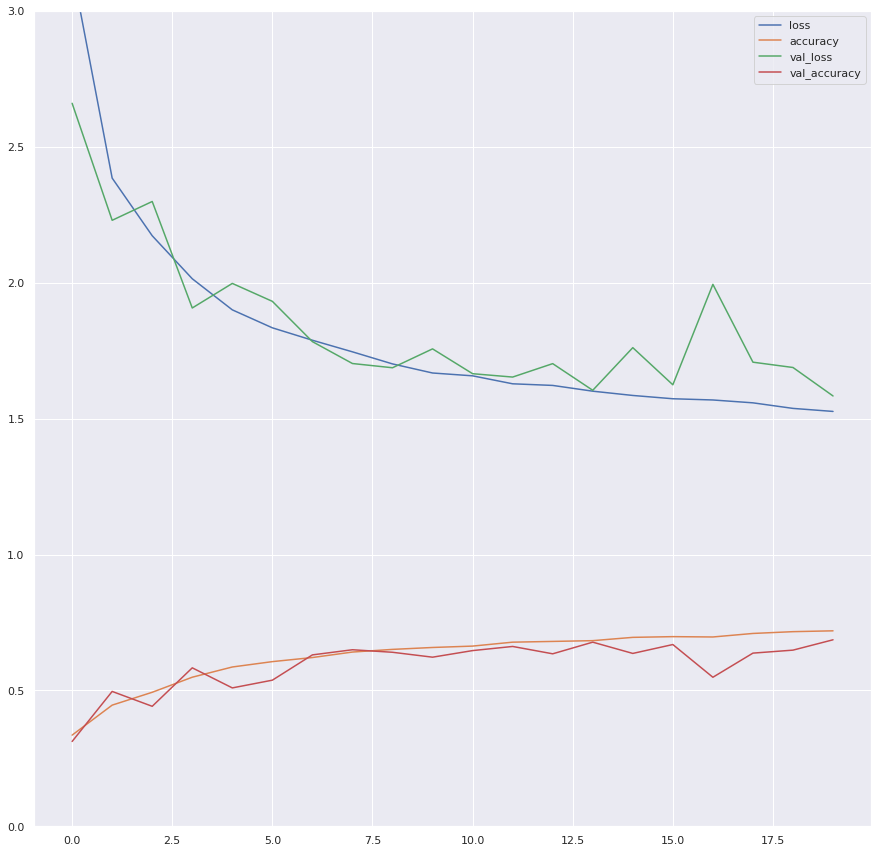

In [16]:
pd.DataFrame(history.history).plot(figsize=(15, 15))
plt.grid(True)
plt.gca().set_ylim(0, 3) # set the vertical range to [0-3]
plt.show()

Je ziet hier dat de trainingsaccuracy na verloop van tijd de validation accuracy achter zich gaat laten, wat betekent dat het model gaat overfitten.

### Classificeren op de testset
Dan ga ik nu kijken hoe goed het model het doet per klasse. Dit is waar het uiteindelijk om gaat. Mijn verwachting is dat dit CNN model beter presteert dan het RandomForest, <br>
maar dat de twee 'probleem'klasses het nog steeds niet goed zullen doen.

In [17]:
#y_test = np.argmax(y_test,axis=1)
predict = best_model.predict(X_test).argmax(axis=1)

In [18]:
#encoder = LabelEncoder()
#y_test = encoder.fit_transform(y_test)
#predict = encoder.fit_transform(predict)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       393
           1       0.00      0.00      0.00        68
           2       0.42      0.17      0.24       218
           3       0.82      0.70      0.75       378
           4       0.71      0.86      0.78       279
           5       0.75      0.46      0.57       380
           6       0.82      0.85      0.83       563
           7       0.64      0.88      0.74       399
           8       0.49      0.57      0.52       516
           9       0.55      0.66      0.60       354

    accuracy                           0.65      3548
   macro avg       0.58      0.57      0.56      3548
weighted avg       0.64      0.65      0.63      3548



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


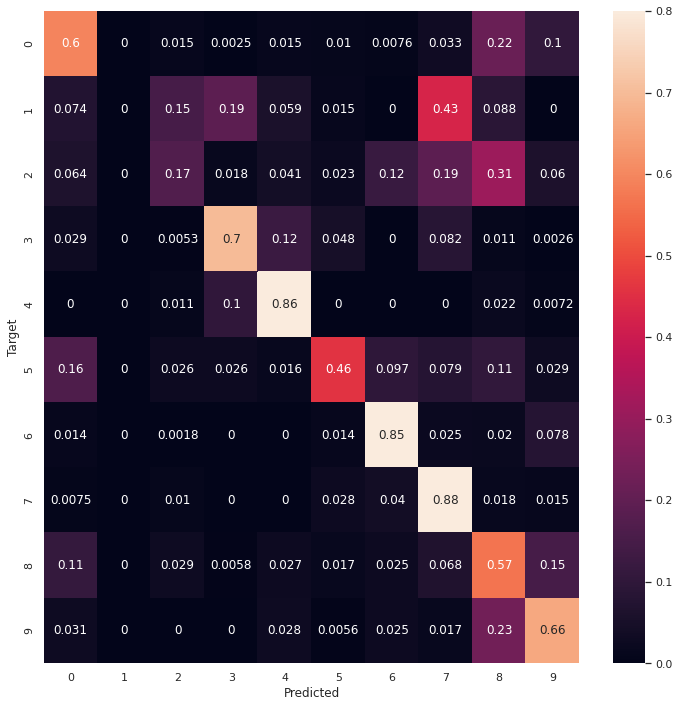

In [19]:
cfm = confusion_matrix(y_test, predict)
cfm_heatmap(cfm, figsize=(12,12), scale='rowwise', vmax= 0.8)

### Observatie
Sommige klasses scoren boven de 80%, wat inderdaad veel beter is dan het Randomforest. 
De 'Disturbed' en 'Cigar Shaped Smooth' klassen presteren nog steeds slecht / het slechtst, zoals ik verwacht had. 

Overall is de performance nog steeds niet heel erg goed. Maar niet iedere dataset levert scores boven de 90% op!

# Eindconclusies

De meeste van mijn hypotheses zijn volgens mij bevestigt. Dit is een uitdagende dataset waardoor het lastig is om hele hoge scores neer te zetten.
Ik zie dat een CNN inderdaad de beste uitkomsten oplevert, dit is ook de meest logische keuze voor image classification.
De 'Cigar Shaped Smooth' is inderdaad lastig gebleken, maar de 'Disturbed' klasse is echt een probleem, en dat ligt aan de data/labeling. 